# Spectral Analysis Part 2 

Today we're going to be learning to use the Multitaper method ([Thomson 1982](https://ieeexplore.ieee.org/document/1456701)).  As discussed in lecture and more below, MTM has some advantages when applied especially to short, complicated, an/or noisy time series.  As [Ghil et al. 2002]() write in their now-classic review of spectral methods:

> MTM reduces the variance of spectral estimates by using a small set of tapers (Thomson, 1982; Percival and Walden, 1993) rather than the unique data taper or spectral window used by the classical methods. The data are premultiplied by orthogonal tapers constructed to minimize the spectral leakage due to the finite length of the time series, and a set of independent estimates of the power spectrum is computed.

MTM seeks to solve one of the problems of estimating spectral density from real observations:  because our observations are typically noisy and always finite, we saw that the Fourier transform based methods can be at times unreliable and/or biased. MTM applies a series of tapers to the problem.  Each taper is orthongonal (uncorrelated) to the other tapers, and therefore multiple estimates of the spectra of a time series can be made that are independent of one another.  This reduces leakage of power between frequencies and also improves the bias vs. variance trade-off, although there can be a cost in terms of the resolution of the spectral estimate.

Today we'll use two different libraries for multitaper spectral analysis.  The first, `multitaper` (https://multitaper.readthedocs.io/en/latest/) is written by a geoscientist.  The second, `nitime` (https://nipy.org/nitime/) is specifically for the neuroscience community, who also have an interest analysis of often noisy signals.  We'll start with `multitaper`. 

## Multitaper methods (MTM) using `multitaper`

While the periodogram and Blackman-Tukey method are well-established for spectral analysis, but there are other more sophisticated and recently developed approaches we can use as well.  Let's install and import some functions from the package `multitaper` (https://github.com/gaprieto/multitaper).  The author of this package is Dr. German Prieto, a seismologist and geophysicist at the Universidad Nacional de Colombia in Bogotá.  He actually published a paper about the package in _Seismological Research Letters_ in 2022:

> Germán A. Prieto; The Multitaper Spectrum Analysis Package in Python. Seismological Research Letters, 93 (3): 1922–1929, doi: https://doi.org/10.1785/0220210332, 2022

Let's use `pip` to install his package.  After you do this the first time you can comment out or remove this cell:

In [2]:
# !conda install multitaper

Let's get our usual libraries:

In [5]:
import numpy as np
import pandas as pd
import scipy as sp

# Matplotlib plotting functionality as well as a helper for axes formatting
import matplotlib.pyplot as plt 
from matplotlib.ticker import ScalarFormatter # this will help us format axes a bit easier

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
# plt.rcParams['font.family'] = 'Helvetica'

# ignore some warnings for lecture, but recommend YOU only do this once you know what those warnings are! 
import warnings
warnings.filterwarnings("ignore")


Next, we import `MTSpec` -- the class in `multitaper` for performing the multitaper method spectral analysis.  You can find the specifications for the class here: https://multitaper.readthedocs.io/en/latest/mtspec.html#mtspec.MTSpec It takes as input the time series, the bandwidth (nw), the number of tapers to use (typically less than should be less than 2*nw-1), and the sampling interval (dt)

In [8]:
from multitaper import MTSpec

Today we'll use MTM on a time series of sea surface temperature (SST) anomalies from the central equatorial tropical Pacific called NINO34.  These are the average SST anomalies in the geographic box bounded by 5N and 5S latitude and 170W and 120W longitude.  This index is used to monitor the El Nino Southern Oscillation (ENSO). Today we'll look at a seasonal average between December and February of each year, with the year corresponding to the January (so, the data for 1998 reflect the SSTs in this region in December 1997, January 1998, and February 1998).  This season reflects the normal peak of ENSO events. The index we'll use comes from the [ERSST dataset](https://journals.ametsoc.org/view/journals/clim/30/20/jcli-d-16-0836.1.xml).  I've truncated the data to the year 1875.

Let's read in the CSV file, which has a column with the year (corresponding to the January of DJF) and the SST anomaly.  This version of the index has had the global warming trend removed and focused on the interannual variability, which is the periodicity where most of the power in the ENSO system resides. 

In [10]:
filename = "erssst_nino34.csv"
df = pd.read_csv(filename,index_col=0)
df

,DJF
Year,
1875,-0.678204
1876,-0.548358
1877,0.897256
1878,2.535730
1879,-0.917934
...,...
2020,0.013400
2021,-1.292510
2022,-1.338730


As usual, we'll plot our data to make sure it looks right before we proceed:

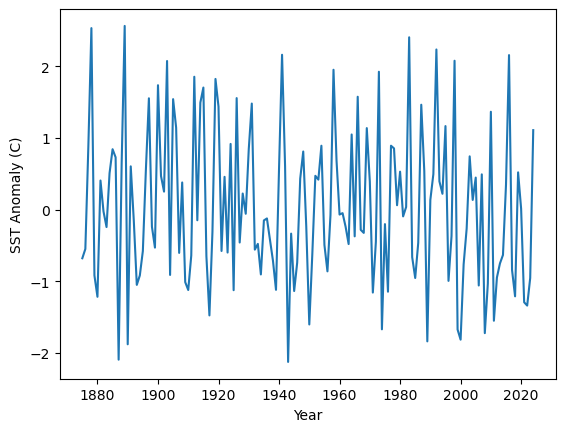

In [12]:
nino34 = df['DJF']

plt.plot(nino34)
plt.xlabel('Year')
plt.ylabel('SST Anomaly (C)')

plt.show()

It is now time to use MTM for spectral analysis.  MTM is often used for short, complicated, an/or noisy time series, and so is quite common in climate science.  As we saw in lecture, as opposed to using single windows or tapers to reduce spectral leakage, MTM uses (as you might guess from the name!) multiple tapers, which allows use to better identify or distinguish between closely spaced (in frequency space) spectral peaks. Because the spectrum results from the average of the spectral estimates across many tapers, the spectral estimate should be more stable, which also improves our confidence in detecting narrowly spaced and/or even weak signals in our data.  A good review of the methods, advantages, and cautions of the MTM methods is available from [Ghil et al. et al. 2002](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2000RG000092).  

[MTSpec](https://multitaper.readthedocs.io/en/latest/mtspec.html#mtspec.MTSpec) takes as input the time series itself, the bandwidth (nw), the number of tapers to use (kspec, typically should be no more than 2*nw-1), and the sampling interval ($dt$).  Like the periodogram, it will return a set of frequencies and their paired power spectral density. 

The main parameters then are the bandwidth and the number of tapers to be used, which contribute to the spectral resolution.  As Ghil et al. (2002) write (calling the bandwidth parameter $p$):

> The choice of the bandwidth and number of tapers ($K$) thus represents the classical trade-off between spectral resolution and the stability or variance reduction properties of the spectral estimate ... The case p=1 and K=1 is simply the single-tapered discrete Fourier transform (DFT) of Blackman and Tukey (1958).  For instrumental climate records, with a typical length of a few hundred points, the choice p=2 and K=3 offers a good compromise between the required frequency resolution for resolving distinct climate signals (e.g., ENSO and decadal-scale variability) and the benefit of multiple spectral degrees of freedom, i.e., of reduced variance (e.g., Mann and Park, 1993). Longer data sets permit the use of a greater number (K) of tapers while maintaining a desired frequency resolution. The optimal choice of p and K depends, in general, on the length and other properties of the time series under study.

We will therefore begin by selecting a bandwidth of 2 and 3 tapers.  But I encourage you to experiment with the bandwidth and tapers and see what the consequences are for the resulting spectrum and your interpretation of it.  For people working with longer paleoclimate time series, it would be appropriate to use many more tapers than we use here for the short instrumental record.  Keep in mind that the choice of these parameters always reflects trade-offs, as described above. 

Let's calculate the MTM spectrum of the winter NINO34 index now.  We'll set out parameters, pass them and the data to `MTSpec`, and remove the 0th frequency from the output as before:

In [14]:
dt   = 1 # what is the time step between samples in our data

# MTM taper parameters
nw    = 2 # the time-bandwidth product: higher values reduce the variance and the frequency resolution, which gives you a smoother but also potentially biased power spectra
kspec = 3 # number of tapers to use: should not exceed (2*nw - 1). Longer datasets can accomodate a greater number of tapers while still maintaining a good frequency resolution

# MTSpec unfortunately expects an ndarray type, so we'll have to convert it first
nino34_array = nino34.to_numpy()

# call the MTM spectrum function to get the power spectral density
psd = MTSpec(nino34_array,nw,kspec,dt=dt)
freq ,spec = psd.rspec() # the spectra will be symmetric, but we only want the positive frequencies for our real data
freq, spec = freq[1:], spec[1:]


Let's make a simple plot of the spectrum:

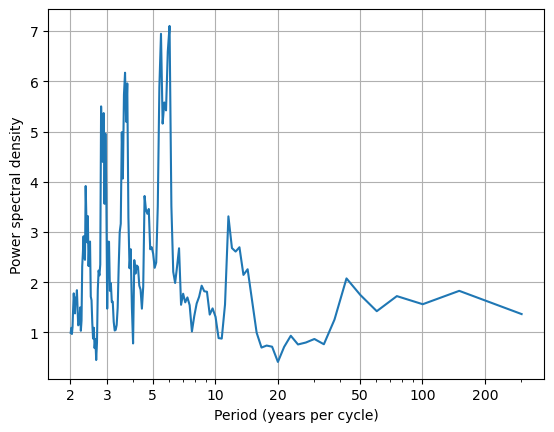

In [19]:
# make a plot of the multitaper spectrum
fig = plt.figure()
ax  = fig.add_subplot()
ax.semilogx(1/freq,spec) # question: how does plotting using loglog vs semilogx change your visual perception of the data and the meaningful cycles?
ax.set_xlabel('Period (years per cycle)') # note that we converted frequency to period be dividing 1 by the frequencies - which can be easier to interpret
ax.set_ylabel('Power spectral density')

# make the x-axis in 'normal' units (not scientific notation)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())  # Use scalar formatter to allow us to avoid scientific notation
plt.gca().ticklabel_format(style='plain', axis='x')  

custom_ticks = [2, 3, 5, 10, 20, 50, 100, 200]  # Some periods to label
plt.xticks(custom_ticks)

plt.grid()
plt.show()


We see a few obvious features (which we might have expected if we know something about ENSO).  There are multiple spectral peaks in the range of 2.5 to 6 years, the characteristic time scale of ENSO variability.  There is also a decadal scale peak (approximately 10 to 15 years), although it has less power than the interannual variability in this equatorial region. 

The multitaper spectrum has a lot of peaks and it would be useful to extract the frequency/period for them.  Here is a small function to do that for us:

In [21]:
# This function returns the N largest spectral peaks based on their spectral power from the output of the MTM analysis
def identify_major_peaks(freq, spec, N=9):
    freq = freq.ravel()  # multitaper class returns 2D arrays, so make this 1D for stacking below
    spec = spec.ravel()  # multitaper class returns 2D arrays, so make this 1D for stacking below
    
    # Calculate period 
    period = 1 / freq
    
    # Now, stack the frequency, period, and spectral power together in a single array for sorting
    combined = np.stack((freq, period, spec), axis=1)
    
    # Sort by the spectral power using argsort 
    sorted_combined = combined[np.argsort(-combined[:, 2])]  # use the negative sign here to get highest-to-lowest ordering
    
    # Return the top N peaks information
    return sorted_combined[:N]

major_peaks = identify_major_peaks(freq, spec,12)

# loop over the output of the function a print to the notebook
for i, peak in enumerate(major_peaks, 1):
    print(f"Rank {i}: Frequency = {float(peak[0]):.3f} cycles/year, Period = {float(peak[1]):.2f} years/cycle, Spectral Power = {float(peak[2]):.2f}")


Rank 1: Frequency = 0.166 cycles/year, Period = 6.02 years/cycle, Spectral Power = 7.10
Rank 2: Frequency = 0.183 cycles/year, Period = 5.47 years/cycle, Spectral Power = 6.95
Rank 3: Frequency = 0.169 cycles/year, Period = 5.90 years/cycle, Spectral Power = 6.59
Rank 4: Frequency = 0.272 cycles/year, Period = 3.67 years/cycle, Spectral Power = 6.17
Rank 5: Frequency = 0.266 cycles/year, Period = 3.76 years/cycle, Spectral Power = 5.96
Rank 6: Frequency = 0.186 cycles/year, Period = 5.38 years/cycle, Spectral Power = 5.89
Rank 7: Frequency = 0.276 cycles/year, Period = 3.63 years/cycle, Spectral Power = 5.73
Rank 8: Frequency = 0.176 cycles/year, Period = 5.68 years/cycle, Spectral Power = 5.58
Rank 9: Frequency = 0.355 cycles/year, Period = 2.81 years/cycle, Spectral Power = 5.50
Rank 10: Frequency = 0.173 cycles/year, Period = 5.79 years/cycle, Spectral Power = 5.42
Rank 11: Frequency = 0.346 cycles/year, Period = 2.89 years/cycle, Spectral Power = 5.37
Rank 12: Frequency = 0.269 cyc

Again, we can see the most prominent spectral peaks are between 2.5 to 6 years. 

We can make more elaborate plots, too. Here's an example of some of the things Matplotlib allows us to do - feel free to play around with this code and annotations to see the range of ways we might display these data:

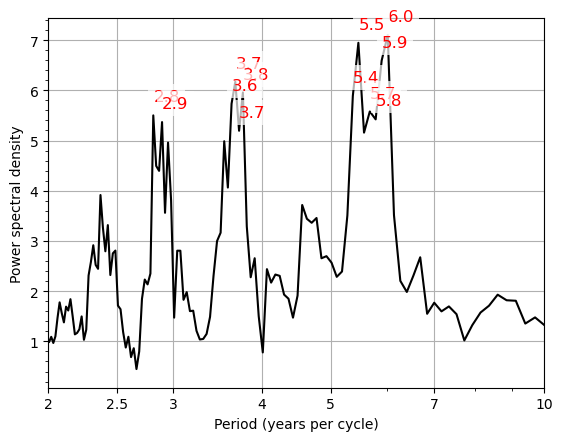

In [24]:
# make a plot of the multitaper spectrum
fig = plt.figure(1)
ax  = fig.add_subplot()
ax.semilogx(1/freq,spec,'k') # how does plotting using loglog vs semilogx change your visual perception of the data and the meaningful cycles?
ax.set_xlabel(r'Period (years per cycle)') # note that we converted frequency to period be dividing 1 by the frequencies - this might be easier to interpret
ax.set_ylabel(r'Power spectral density')

# Annotate the top N peaks 
for peak in major_peaks:
    peak_period = peak[1]  # the period (in years)
    peak_spec = peak[2]  # spectral power

    # Annotate on the plot
    plt.annotate(f'{peak_period:.1f}',          # the text for annotation
                 xy=(peak_period, peak_spec),   # position of the annotation
                 xytext=(0, 10),                # offset for the text (trying to avoid obscuring the peak and other numbers)
                 textcoords='offset points',
                 bbox=dict(boxstyle="square", facecolor="white", edgecolor="none", alpha=0.70),
                 fontsize=12, color='red')

# make the x-axis in 'normal' units (not scientific notation)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())  # Use scalar formatter to allow us to avoid scientific notation
plt.gca().ticklabel_format(style='plain', axis='x')  

plt.xlim([2,10])
# Explicitly set custom ticks and tick labels
custom_ticks = [2, 2.5, 3, 4, 5, 7, 10]
ax.set_xticks(custom_ticks)
ax.set_xticklabels([str(tick) for tick in custom_ticks])  # Ensure labels match ticks exactly

ax.minorticks_on()
ax.xaxis.set_minor_formatter(plt.NullFormatter())

plt.grid("both")
plt.show()

Now, the question you might be asking - which of those peak are _significant_?  There are many ways we might go about determining that using `multitaper` but they are not built-in to the function (and this could, if you'd like, form a basis for your final project and paper), but let's switch now to `nitime`, which makes Monte Carlo significance testing quite simple. 

## Using `nitime` for multitaper spectral analysis and significance testing

Which of our peaks are significant and how might we evaluate this?  We might suspect the largest in the interannual periodicities are, but how can we test this?  Once again, the wonders of Monte Carlo sampling will help us!

Unfortunately, `multitaper` doesn't contain built-in functionality for this kind of simulation approach to significance (we'd have to call some other libraries).  However, `nitime` does (https://nipy.org/nitime/).  This package was created for time series (including spectral) analysis of **neuroscience** data, but the basic principles of time series analysis used in the package apply generally to our data as well.

Let's install `nitime` first:

In [27]:
!pip install nitime

   ---------------------------------------- 0.0/4.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.1 MB 326.8 kB/s eta 0:00:13
   - -------------------------------------- 0.1/4.1 MB 1.1 MB/s eta 0:00:04
   ---- ----------------------------------- 0.4/4.1 MB 2.3 MB/s eta 0:00:02
   ------- -------------------------------- 0.8/4.1 MB 3.4 MB/s eta 0:00:01
   ---------- ----------------------------- 1.1/4.1 MB 4.3 MB/s eta 0:00:01
   --------------- ------------------------ 1.5/4.1 MB 5.1 MB/s eta 0:00:01
   ------------------- -------------------- 2.0/4.1 MB 6.0 MB/s eta 0:00:01
   ------------------------ --------------- 2.5/4.1 MB 6.6 MB/s eta 0:00:01
   ----------------------------- ---------- 3.0/4.1 MB 7.1 MB/s eta 0:00:01
   -----------------------------------

From `nitime`, we'll import the components that allow us to calcuate power spectral density using the Multitaper method: 


In [29]:
import nitime.algorithms as tsa
import nitime.utils as utils
from nitime.viz import winspect
from nitime.viz import plot_spectral_estimate

We can now apply the `nitime` spectral analysis to the NINO34 data, as we did above.  The `tsa.multi_taper_psd` function (see [here](https://nipy.org/nitime/api/generated/nitime.algorithms.spectral.html#nitime.algorithms.spectral.multi_taper_psd) takes our data (as an ndarray again), the sampling interval (Fs), and the bandwidth (NW).  Unlike multitaper, it sets the number of tapers automatically based on the bandwidth, here passed as NW.  There are additional options you see, but we'll leave those for you to explore in the future. 

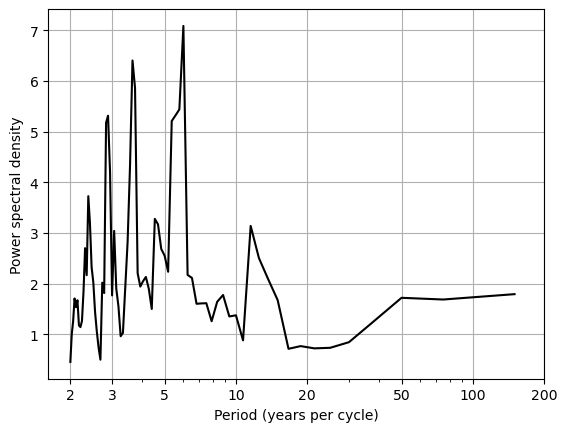

In [31]:
# this is the main function for MTM in nitime
f, psd, nu = tsa.multi_taper_psd(nino34_array, Fs=1, NW=nw, adaptive=False, jackknife=False) # note that this will give us 3 tapers, as above

# make the period array from the frequencies
per = 1/f

# make a plot of the multitaper spectrum
fig = plt.figure()
ax  = fig.add_subplot()
ax.semilogx(per,psd,color='k')

ax.set_xlabel('Period (years per cycle)') 
ax.set_ylabel('Power spectral density')

# make the x-axis in 'normal' units (not scientific notation)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())  # Use scalar formatter to allow us to avoid scientific notation
plt.gca().ticklabel_format(style='plain', axis='x')  

custom_ticks = [2, 3, 5, 10, 20, 50, 100, 200] 
plt.xticks(custom_ticks)

plt.grid()
plt.show()

Should look similar to what we saw with `multitaper`.

Note that, unlike `multitaper` where you can specify the number of tapers as well, the bandwidth of the windowing function (NW in the function call above) will be used internally by `nitime` to determine the number tapers to use. 

Now, recall that we said that many geophysical time series have a 'red' spectrum.  Because of this, we should really test to see whether the peaks here are meaningful or significant vs. what could be generated from a simple red noise process. For our significance test, we are going to generate artificial red noise series with similar background spectral properties to our real NINO34 record, and then see if it is possible or likely to get the interannual by chance.

We'll use another part of the `nitime` package here to first estimate the autoregressive properties of our actual signal (`AR_est_YW`) and then use those autoregressive properties to generate random noise (`ar_generator`) that are similar to our SST record:

In [35]:
# let's just do one simulation and take a look:
coef,sigma=tsa.AR_est_YW(nino34_array,1) # this line estimates the first order autoregressive (AR1) coefficient of our NINO34 series
X_ar, noise, aph = utils.ar_generator(len(nino34_array), sigma, coef) # this line then generates a red noise time series with that AR1 property and the same length as our real series

# now, calculate the spectrum of the red noise series
f_ar, psd_mt_ar, nu_m = tsa.multi_taper_psd(X_ar ,Fs=1.0, NW=nw, adaptive=False, jackknife=False)
pmtm_ar = psd_mt_ar

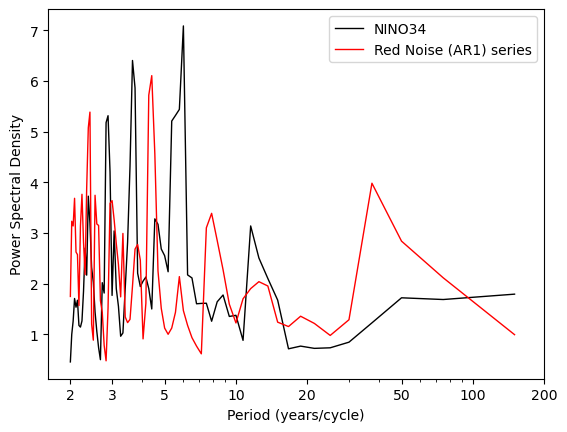

In [37]:
# let's plot our real spectrum and the red noise spectrum now
ax1=plt.subplot(1,1,1)

# Plot the spectra both in log-log space:
plt.semilogx(1/f,psd, label='NINO34',color='k',linewidth=1.0)
plt.semilogx(1/f_ar,pmtm_ar, label='Red Noise (AR1) series',color='r',linewidth=1.0)

# make the x-axis in 'normal' units (not scientific notation)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())  # Use scalar formatter to allow us to avoid scientific notation
plt.gca().ticklabel_format(style='plain', axis='x')  

custom_ticks = [2, 3, 5, 10, 20, 50, 100, 200]  
plt.xticks(custom_ticks)

plt.xlabel('Period (years/cycle)')
plt.ylabel('Power Spectral Density')

plt.legend()

plt.show()

Interesting!  In general, the red noise series we generated has some similar features as the real time series - there are some peaks in the interannual and so evidence of power in the decadal and longer frequencies.  But this is only one simulation - if you run the two code cells above over and over again, you'll see different manifestations of the red noise spectrum, each having some similar general features to the NINO34 spectrum, but everyone a bit different. We can't really do this significance test with a single red noise realization, obviously. So let's do this again many (many) times.  We're going to run 1000 iterations of generating red noise conditioned on our actual data, then estimate the power spectrum and save it.  Once we're done, we can look at say the 5th and 95th percentiles of all the red noise spectra we simulated and use these as confidence intervals:

In [40]:
from scipy.stats.mstats import mquantiles # nice little helper function for quickly getting quantiles or percentiles

# AR1 Monte Carlo simulation - depending on your computer, you might want to start small! 
iterations = 1000 # set small at first - can increase to 1,000 or 10,000 if your computer can handle it
pmtm_ar=np.zeros((len(f),iterations)) # we're going to use this array full of zeros to store our null spectra
coef,sigma=tsa.AR_est_YW(nino34_array,1) # here we estimate the AR1 coefficients ... we can do this outside the loop since it doesn't change

# here is the Monte Carlo itself - 
for i in range(iterations): # we'll do this [iterations] times ...
     X_ar, noise, aph = utils.ar_generator(len(nino34_array), sigma, coef) # generate a new AR1 noise time series
     f_ar, psd_mt_ar, nu_m = tsa.multi_taper_psd(X_ar, Fs=1.0, NW=nw, adaptive=False, jackknife=False )  # then calculate the MTM spectrum of the noise series
     pmtm_ar[:,i] = psd_mt_ar # save that noise spectrum before looping over again

pq  = mquantiles(pmtm_ar, prob=[0.05, 0.5, 0.95], axis=1) # get the median and some upper (95th) and lower (5th) quantiles
pq # what is in the variable pq now? This is a 'Masked Array' data type containing, the 5th, 50th (median), and 95th quantiles for each frequency band

masked_array(
  data=[[0.05037862, 0.51805054, 2.31830289],
        [0.25287731, 1.23468319, 3.61726809],
        [0.56653153, 1.86458631, 4.44234776],
        [0.60528414, 1.96158804, 4.55992336],
        [0.59409869, 1.99161489, 4.68199724],
        [0.63334394, 2.00241065, 4.577506  ],
        [0.60160834, 1.92472946, 4.70145377],
        [0.58263601, 1.90718297, 4.36470058],
        [0.57097148, 1.92261105, 4.63931075],
        [0.62044924, 1.95604741, 4.64321031],
        [0.59939169, 1.98305997, 4.67170488],
        [0.62687678, 1.99444424, 4.80206457],
        [0.62192117, 2.00670778, 4.62674474],
        [0.62828679, 2.03199604, 4.66648494],
        [0.65170452, 2.02710521, 4.8555361 ],
        [0.60218391, 2.02127041, 4.63615325],
        [0.67913807, 1.99018269, 4.56657965],
        [0.62228804, 2.03538963, 4.616895  ],
        [0.60400004, 1.98309136, 4.73479227],
        [0.59994687, 1.94497186, 4.63714305],
        [0.62242479, 2.00050746, 4.72013862],
        [0.58784401,

We'll now plot our real NINO34 spectrum and compare it to the range of possible spectra generated by our red noise Monte Carlo procedure:

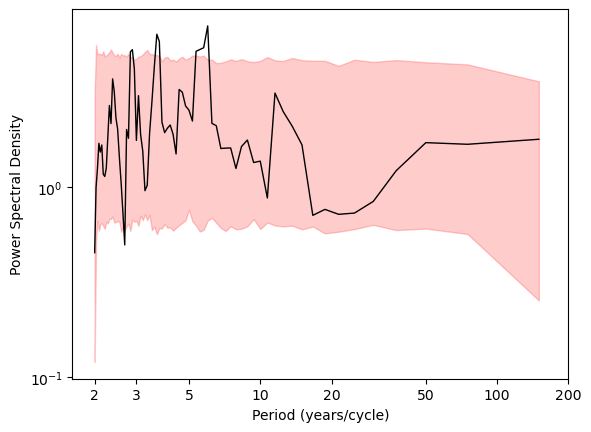

In [42]:
ax1=plt.subplot(1,1,1)

# Plot the real spectra in log-log space:
plt.loglog(1/f,psd, color='k',linewidth=1.0)

# plot the envelope between the 5th and 95th percentile of the noise spectra
plt.fill_between(1/f_ar,pq[:,0],pq[:,2],facecolor='red',edgecolor='red',alpha=0.20)

# make the x-axis in 'normal' units (not scientific notation)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())  # Use scalar formatter to allow us to avoid scientific notation
plt.gca().ticklabel_format(style='plain', axis='x')  

custom_ticks = [2, 3, 5, 10, 20, 50, 100, 200] 
plt.xticks(custom_ticks)

plt.xlabel('Period (years/cycle)')
plt.ylabel('Power Spectral Density')

plt.minorticks_off()

plt.show()

What we now observe is the 90% envelope where random red noise with the same AR1 coefficient of the NIN034 was able to generate power.  What this suggests is that the peaks near 4 years, 5-6 years, and 3 fall above that confidence interval, which we may interpret as indicating they are 'significant' at least compared to our null (red noise model).  The rest of the NINO34 spectrum, however, falls within the envelope of what could have been produced by a simple noise process.

There are many nuances to this we'll want to discuss in class, some of which are methodological and some of which are philosophical.  

## Next steps

1. Experiment with different bandwidth and taper numbers - how does this affect the spectral resolution and variance of the MTM spectra? 
2. Above we used a first-order red noise process as our null in the Monte Carlo significance test - what is the effect of choosing different AR models? 
3. `multitaper` includes several additional options we didn't use.  Experiment with the use of the jacknife option for estimating confidence intervals (or errors) in the spectra